# Step 2: Building GTFS graphs and merging it with a walking graph
We heavily follow Kuan Butts's Calculating Betweenness Centrality with GTFS blog post: https://gist.github.com/kuanb/c54d0ae7ee353cac3d56371d3491cf56

### The peartree (https://github.com/kuanb/peartree) source code was modified. Until code is merged you should use code from this fork: https://github.com/d3netxer/peartree

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
from shapely.geometry import Point

In [49]:
import partridge as ptg

In [50]:
import os, sys

In [51]:
sys.path.append(r"C:\repos\peartree")

import peartree as pt

In [52]:
print(pt.__file__)

C:\repos\peartree\peartree\__init__.py


In [53]:
path = r'C:\repos\GOST_PublicGoods\Implementations\GTFS_accessibility_analysis_Cap_Haitien_Haiti\input_folder\cap_haitien_gtfs.zip'

### Build a graph from service_0001
service_0001 is on the weekends, so below we are choosing a data that lands on a weekend

In [54]:
# from: http://simplistic.me/playing-with-gtfs.html
import datetime

service_ids_by_date = ptg.read_service_ids_by_date(path)
service_ids = service_ids_by_date[datetime.date(2019, 6, 29)]

print(f"service_ids is {service_ids}")

# view lets you filter before you load the feed. For example, below you are filtering by the service_ids
feed_0001 = ptg.load_feed(path, view={
    'trips.txt': {
        'service_id': service_ids,
    },
})

service_ids is frozenset({'service_0001'})


In [55]:
feed_0001.calendar

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,service_0001,0,0,0,0,0,1,1,2019-06-29,2020-07-29


### give all trips a direction of 0
PearTree wants directions assigned

In [56]:
feed_0001.trips['direction_id'] = 0

### Preview the GTFS network

In [57]:
# Set a target time period to summarize impedance
start = 0  # 0:00 
end = 24*60*60  # 24:00 

# Converts feed subset into a directed
# network multigraph
G = pt.load_feed_as_graph(feed_0001, start, end, add_trips_per_edge=True)

C:\Users\war-machine\anaconda3\envs\gostnets3_8\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


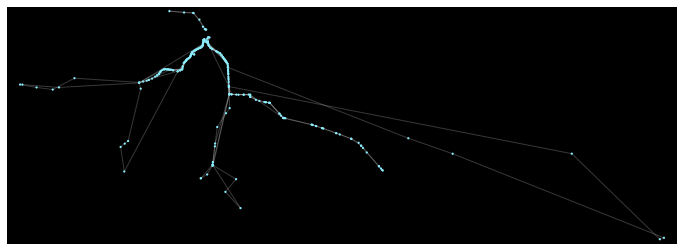

In [58]:
fig, ax = ox.plot_graph(G,
                            figsize=(12,12),
                            show=False,
                            close=False,
                            node_color='#8aedfc',
                            node_size=5,
                            edge_color='#e2dede',
                            edge_alpha=0.25,
                            bgcolor='black')

In [59]:
# PearTree prepends the stop ids with a code the is different each time it loads a graph
list(G.edges)

[('7W4V3_stop_0119', '7W4V3_stop_0096', 0),
 ('7W4V3_stop_0143', '7W4V3_stop_0260', 0),
 ('7W4V3_stop_0143', '7W4V3_stop_0081', 0),
 ('7W4V3_stop_0143', '7W4V3_stop_0154', 0),
 ('7W4V3_stop_0176', '7W4V3_stop_0074', 0),
 ('7W4V3_stop_0217', '7W4V3_stop_0001', 0),
 ('7W4V3_stop_0217', '7W4V3_stop_0034', 0),
 ('7W4V3_stop_0232', '7W4V3_stop_0104', 0),
 ('7W4V3_stop_0250', '7W4V3_stop_0228', 0),
 ('7W4V3_stop_0017', '7W4V3_stop_0076', 0),
 ('7W4V3_stop_0076', '7W4V3_stop_0087', 0),
 ('7W4V3_stop_0076', '7W4V3_stop_0103', 0),
 ('7W4V3_stop_0018', '7W4V3_stop_0153', 0),
 ('7W4V3_stop_0195', '7W4V3_stop_0240', 0),
 ('7W4V3_stop_0195', '7W4V3_stop_0197', 0),
 ('7W4V3_stop_0195', '7W4V3_stop_0135', 0),
 ('7W4V3_stop_0173', '7W4V3_stop_0219', 0),
 ('7W4V3_stop_0181', '7W4V3_stop_0015', 0),
 ('7W4V3_stop_0161', '7W4V3_stop_0184', 0),
 ('7W4V3_stop_0161', '7W4V3_stop_0083', 0),
 ('7W4V3_stop_0147', '7W4V3_stop_0068', 0),
 ('7W4V3_stop_0147', '7W4V3_stop_0168', 0),
 ('7W4V3_stop_0029', '7W4V3_stop

In [60]:
#list(G.edges(data='True'))

In [61]:
len(G.nodes)

261

### Inspect edge data, and you should see the length attribute, which is the time in seconds needs to traverse an edge. The trips attribute represents how many trips cross that edge.

In [62]:
for edge in list(G.edges):
    print(G.get_edge_data(edge[0],edge[1]))

{0: {'length': 2119.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 1462.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 74.0, 'trips': 2, 'mode': 'transit'}}
{0: {'length': 122.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 706.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 1213.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 648.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 1257.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 2657.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 161.0, 'trips': 2, 'mode': 'transit'}}
{0: {'length': 108.5, 'trips': 4, 'mode': 'transit'}}
{0: {'length': 137.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 69.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 61.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 16.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 242.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 170.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 145.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 42.0, 'trips

### get feed 2

In [63]:
service_ids_by_date = ptg.read_service_ids_by_date(path)
service_ids = service_ids_by_date[datetime.date(2019,8,6)]

print(f"service_ids is {service_ids}")

# view lets you filter before you load the feed. For example, below you are filtering by the service_ids
feed_0002 = ptg.load_feed(path, view={
    'trips.txt': {
        'service_id': service_ids,
    },
})

service_ids is frozenset({'service_0002'})


### Inspect graph as a shapefile
Used for testing

In [64]:
# Get reference to GOSTNets
#sys.path.append(r'C:\repos\GOSTnets')
#import GOSTnets as gn

In [65]:
#gn.save(G,"gtfs_export_cap_haitien_service0001",r"temp")
#gn.save(G,"gtfs_export_cap_haitien_service0002",r"temp")
# Also these saved edges will be used in the optional PostProcessing notebook to compare differences between the two graphs

note: On inspection the edges have a length field. This length field is the average traversal time per edge based on the GTFS data in seconds.

## Merge a walk network
following this blog post: http://kuanbutts.com/2018/12/24/peartree-with-walk-network/

## For the Step three you need to merge the advanced snapped graphs with the GTFS feed
## For the betweeness centrality notebook you will merge the basic graph with the GTFS feed

In [66]:
# load existing graphs from step 1

G_walk_basic = nx.read_gpickle(r"temp\clipped_cap_haitien_walk_w_ferries_via_osmnx.pickle")
G_walk_flooded_basic = nx.read_gpickle(r"temp\flooded_clipped_cap_haitien_walk_w_ferries_via_osmnx.pickle")

G_walk_adv_snap = nx.read_gpickle(r"temp\clipped4_cap_haitien_walk_w_ferries_via_osmnx_origins_adv_snap.pickle")
G_walk_flooded_adv_snap = nx.read_gpickle(r"temp\flooded4_clipped_cap_haitien_drive_w_ferries_via_osmnx_origins_adv_snap.pickle")
G_drive_adv_snap = nx.read_gpickle(r"temp\clipped4_cap_haitien_drive_w_ferries_via_osmnx_origins_adv_snap.pickle")

In [67]:
print(nx.info(G))

Name: 7W4V3
Type: MultiDiGraph
Number of nodes: 261
Number of edges: 342
Average in degree:   1.3103
Average out degree:   1.3103


In [68]:
graph_dict = {'G_walk_basic': G_walk_basic,
              'G_walk_flooded_basic': G_walk_flooded_basic,
              'G_walk_adv_snap': G_walk_adv_snap,
              'G_walk_flooded_adv_snap': G_walk_flooded_adv_snap,
              'G_drive_adv_snap': G_drive_adv_snap}

### For Walk graphs assign traversal times in seconds to edges
Since peartree represents edge length (that is the impedance value associated with the edge) in seconds; we will need to convert the edge values that are in meters into seconds:

In [69]:
def assign_traversal_times(G):
    walk_speed = 3.5 #km per hour; about 3 miles per hour
    ferry_speed = 15

    # Make a copy of the graph in case we make a mistake
    G_adj = G.copy()

    ferry_count = 0

    # Iterate through and convert lengths to seconds
    for from_node, to_node, edge in G_adj.edges(data=True):
        orig_len = edge['length']

        # Note that this is a MultiDiGraph so there could
        # be multiple indices here

        for edge in G_adj[from_node][to_node]:
            orig_len =  G_adj[from_node][to_node][edge]['length']
            G_adj[from_node][to_node][edge]['orig_length'] = orig_len

            #if G_adj[from_node][to_node][0].get('ferry')

            if 'ferry' in G_adj[from_node][to_node][edge]:
                ferry_count += 1

                ferry_var = G_adj[from_node][to_node][edge]['ferry']

                if ferry_var == "unclassified":
                    #print(G_adj[from_node][to_node][edge]['ferry'])
                    #print(G_adj[from_node][to_node][edge])

                    # Conversion of walk speed and into seconds from meters
                    kmph = (orig_len / 1000) / ferry_speed
                    in_seconds = kmph * 60 * 60
                    G_adj[from_node][to_node][edge]['length'] = in_seconds

                    # And state the mode, too
                    G_adj[from_node][to_node][edge]['mode'] = 'ferry'
                else:
                    # Conversion of walk speed and into seconds from meters
                    kmph = (orig_len / 1000) / walk_speed
                    in_seconds = kmph * 60 * 60
                    G_adj[from_node][to_node][edge]['length'] = in_seconds

                    # And state the mode, too
                    G_adj[from_node][to_node][edge]['mode'] = 'walk'
            else:
                # Conversion of walk speed and into seconds from meters
                kmph = (orig_len / 1000) / walk_speed
                in_seconds = kmph * 60 * 60
                G_adj[from_node][to_node][edge]['length'] = in_seconds

                # And state the mode, too
                G_adj[from_node][to_node][edge]['mode'] = 'walk'
    
    # So this should be easy - just go through all nodes
    # and make them have a 0 cost to board
    for i, node in G_adj.nodes(data=True):
        G_adj.nodes[i]['boarding_cost'] = 0
    
    return G_adj

In [70]:
adj_graph_dict = {}
for key,value in graph_dict.items():
    adj_graph_dict[key] = assign_traversal_times(graph_dict[key])

In [71]:
adj_graph_dict

{'G_walk_basic': <networkx.classes.multidigraph.MultiDiGraph at 0x1c6d281cf40>,
 'G_walk_flooded_basic': <networkx.classes.multidigraph.MultiDiGraph at 0x1c6b986ab20>,
 'G_walk_adv_snap': <networkx.classes.multidigraph.MultiDiGraph at 0x1c6b97f63a0>,
 'G_walk_flooded_adv_snap': <networkx.classes.multidigraph.MultiDiGraph at 0x1c6d29f73d0>,
 'G_drive_adv_snap': <networkx.classes.multidigraph.MultiDiGraph at 0x1c6b994bfd0>}

In [72]:
adj_graph_dict['G_walk_flooded_basic'][619360366][2176357009][0]

{'osmid': 48390244,
 'ref': 'RN 1',
 'name': 'Route Nationale # 1',
 'highway': 'primary',
 'oneway': False,
 'length': 36.10285714285714,
 'orig_length': 35.1,
 'mode': 'walk'}

In [73]:
adj_graph_dict['G_walk_flooded_basic'][330725194][2322274029][0]

{'osmid': 218402959,
 'name': 'Route Boisdaut',
 'highway': 'unclassified',
 'oneway': False,
 'length': 260.24526367346937,
 'geometry': <shapely.geometry.linestring.LineString at 0x1c6d2a0e070>,
 'orig_length': 253.01622857142857,
 'mode': 'walk'}

In [74]:
adj_graph_dict['G_walk_flooded_basic'][330725194][2322274029][1]

{'osmid': 223315661,
 'highway': 'path',
 'oneway': False,
 'length': 512.0342595918368,
 'geometry': <shapely.geometry.linestring.LineString at 0x1c6d2a0e3d0>,
 'orig_length': 497.81108571428575,
 'mode': 'walk'}

In [75]:
adj_graph_dict['G_walk_flooded_basic'][6770195160]

AdjacencyView({8831849375: {0: {'osmid': 721705086, 'highway': 'residential', 'oneway': False, 'length': 66.18857142857142, 'orig_length': 64.35, 'mode': 'walk'}}, 8831849379: {0: {'osmid': 952714381, 'highway': 'residential', 'oneway': False, 'length': 93.51977142857145, 'orig_length': 90.922, 'mode': 'walk'}}, 614618596: {0: {'osmid': 952714381, 'highway': 'residential', 'oneway': False, 'length': 144.8578285714286, 'orig_length': 140.834, 'mode': 'walk'}}, 8831849374: {0: {'osmid': 954236059, 'highway': 'residential', 'oneway': False, 'length': 66.17417142857143, 'orig_length': 64.336, 'mode': 'walk'}}})

In [76]:
sys.path.append(r'C:\repos\GOSTnets')
import GOSTnets as gn

In [77]:
gn.example_node(adj_graph_dict['G_walk_flooded_basic'],2)

(330725194, {'y': 19.71362, 'x': -72.175561, 'street_count': 4, 'boarding_cost': 0})
(330725346, {'y': 19.7546605, 'x': -72.204247, 'street_count': 4, 'boarding_cost': 0})


In [78]:
# testing
#list(G_adj.edges(data=True))[1]

In [79]:
#G_walk[1110007004][9990002810][0]['length']
#G_adj[619360366][2176357009][0]

## work on assigning speeds to the drive graph, remember that the 'length' attribute should be used to save time

In [80]:
gn.example_edge(adj_graph_dict['G_drive_adv_snap'],3)

(330725346, 614908804, {'geometry': <shapely.geometry.linestring.LineString object at 0x000001C6E1EA5F40>, 'lanes': nan, 'highway': 'unclassified', 'ref': nan, 'osmid': 48413285, 'oneway': False, 'ferry': nan, 'access': nan, 'length': 44.83748571428571, 'name': 'Rue 2', 'junction': nan, 'est_width': nan, 'bridge': nan, 'maxspeed': nan, 'node_ID': nan, 'orig_length': 43.592, 'mode': 'walk'})
(330725346, 614908783, {'geometry': <shapely.geometry.linestring.LineString object at 0x000001C6E1EA5F70>, 'lanes': nan, 'highway': 'unclassified', 'ref': nan, 'osmid': 48413285, 'oneway': False, 'ferry': nan, 'access': nan, 'length': 50.101714285714294, 'name': 'Rue 2', 'junction': nan, 'est_width': nan, 'bridge': nan, 'maxspeed': nan, 'node_ID': nan, 'orig_length': 48.71, 'mode': 'walk'})
(330725346, 616793092, {'geometry': <shapely.geometry.linestring.LineString object at 0x000001C6E1EA5FA0>, 'lanes': nan, 'highway': 'residential', 'ref': nan, 'osmid': 50759615, 'oneway': False, 'ferry': nan, 'ac

In [81]:
adj_graph_dict['G_drive_adv_snap'] = gn.convert_network_to_time(adj_graph_dict['G_drive_adv_snap'],'orig_length', output_time_col = 'length')

In [82]:
gn.example_edge(adj_graph_dict['G_drive_adv_snap'],3)

(330725346, 614908804, {'geometry': <shapely.geometry.linestring.LineString object at 0x000001C6E1EA5F40>, 'lanes': nan, 'highway': 'unclassified', 'ref': nan, 'osmid': 48413285, 'oneway': False, 'ferry': nan, 'access': nan, 'length': 7.84656, 'name': 'Rue 2', 'junction': nan, 'est_width': nan, 'bridge': nan, 'maxspeed': nan, 'node_ID': nan, 'orig_length': 43.592, 'mode': 'drive'})
(330725346, 614908783, {'geometry': <shapely.geometry.linestring.LineString object at 0x000001C6E1EA5F70>, 'lanes': nan, 'highway': 'unclassified', 'ref': nan, 'osmid': 48413285, 'oneway': False, 'ferry': nan, 'access': nan, 'length': 8.767800000000001, 'name': 'Rue 2', 'junction': nan, 'est_width': nan, 'bridge': nan, 'maxspeed': nan, 'node_ID': nan, 'orig_length': 48.71, 'mode': 'drive'})
(330725346, 616793092, {'geometry': <shapely.geometry.linestring.LineString object at 0x000001C6E1EA5FA0>, 'lanes': nan, 'highway': 'residential', 'ref': nan, 'osmid': 50759615, 'oneway': False, 'ferry': nan, 'access': na

## The drive graph will be used without merging with GTFS network

In [83]:
gn.save(adj_graph_dict['G_drive_adv_snap'],"clipped4_cap_haitien_drive_w_ferries_via_osmnx_w_time_adv_snap",r"temp")

## Also for the step 3 notebook we will be using versions of the advanced snap walk graphs that are not merged with the GTFS network

In [84]:
gn.save(adj_graph_dict['G_walk_adv_snap'],"clipped4_cap_haitien_walk_w_ferries_via_osmnx_origins_w_time_adv_snap",r"temp")

gn.save(adj_graph_dict['G_walk_flooded_adv_snap'],"flooded4_clipped_cap_haitien_walk_w_ferries_via_osmnx_w_time_adv_snap",r"temp")

## Loading the feeds as graphs with the walking graph as the existing graph
Now that the two graphs have the same internal structures, we can load the walk network onto the transit network with the following peartree helper method.

In [85]:
adj_graph_dict_merge = adj_graph_dict.copy()
adj_graph_dict_merge.pop('G_drive_adv_snap')

In [86]:
adj_graph_dict_merge

{'G_walk_basic': <networkx.classes.multidigraph.MultiDiGraph at 0x1c6d281cf40>,
 'G_walk_flooded_basic': <networkx.classes.multidigraph.MultiDiGraph at 0x1c6b986ab20>,
 'G_walk_adv_snap': <networkx.classes.multidigraph.MultiDiGraph at 0x1c6b97f63a0>,
 'G_walk_flooded_adv_snap': <networkx.classes.multidigraph.MultiDiGraph at 0x1c6d29f73d0>}

In [87]:
for key, value in adj_graph_dict_merge.items():
    print(key)

G_walk_basic
G_walk_flooded_basic
G_walk_adv_snap
G_walk_flooded_adv_snap


In [88]:
# Now that we have a formatted walk network
# it should be easy to reload the peartree graph
# and stack it on the walk network
start = 0  # 0:00 
end = 24*60*60  # 24:00 

for key, value in adj_graph_dict_merge.items():

    #feeds = {'service0001':feed_0001,'service0002':feed_0002}
    feeds = {'service0001':feed_0001}
    
    for feed in feeds.items():
        G_adj_copy = adj_graph_dict_merge[key].copy()
        # Note this will be a little slow - an optimization here would be
        # to have coalesced the walk network
        %time G = pt.load_feed_as_graph(feed[1], start, end, existing_graph=G_adj_copy, impute_walk_transfers=True, add_trips_per_edge=True)

        # compatible with NetworkX 2.4
        list_of_subgraphs = list(G.subgraph(c).copy() for c in nx.weakly_connected_components(G))
        max_graph = None
        max_edges = 0
        for i in list_of_subgraphs:
            if i.number_of_edges() > max_edges:
                max_edges = i.number_of_edges()
                max_graph = i

        # set your graph equal to the largest sub-graph
        G = max_graph

        # save again and inspect
        gn.save(G,f"4_{key}_cap_haitien_gtfs_merged_impute_walk_{feed[0]}",r"temp")
        
        #gn.save(G,f"clipped3_flooded_non_adv_gtfs_export_cap_haitien_merged_impute_walk_{feed[0]}",r"temp")
        #gn.save(G,f"clipped3_non_adv_gtfs_export_cap_haitien_merged_impute_walk_{feed[0]}",r"temp")
        #gn.save(G,f"clipped3_gtfs_export_cap_haitien_merged_impute_walk_{feed[0]}",r"temp")
        #gn.save(G,f"flooded3_clipped3_gtfs_export_cap_haitien_merged_impute_walk_{feed[0]}",r"temp")

Wall time: 2.66 s
Wall time: 2.5 s
Wall time: 4.5 s
Wall time: 4.71 s


## Visualize the last merged feed in the loop

In [89]:
#G.graph['crs'] = 'epsg:4326'
#G.graph

In [90]:
#G.nodes[6770195160]

In [91]:
# fig, ax = ox.plot_graph(G,
#                             figsize=(12,12),
#                             show=False,
#                             close=False,
#                             node_color='#8aedfc',
#                             node_size=5,
#                             edge_color='#e2dede',
#                             edge_alpha=0.25,
#                             bgcolor='black')